In [1]:
# Imports
from os import makedirs
from os.path import join
import pickle
import numpy as np
rng_seed = 399
np.random.seed(rng_seed)
from scipy.spatial.distance import pdist, cdist, squareform
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm.auto import tqdm
import sys
sys.path.append("..")

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn_extra.cluster import KMedoids

from utils import get_model_checkpoint_filepaths
from analysis_utils import words_in_clusters, plot_silhouette_scores

In [2]:
# Get last word embeddings from training
checkpoint_filepaths_dict = get_model_checkpoint_filepaths(
    output_dir="../output/word2vec_training/17-Oct-2020_01-00-56",
    model_name="word2vec",
    dataset_name="enwiki",
)
last_embedding_weights_filepath = checkpoint_filepaths_dict["intermediate_embedding_weight_filepaths"][-1]
last_embedding_weights = np.load(last_embedding_weights_filepath, mmap_mode="r").astype(np.float64)

In [3]:
# Load words and create word to int lookup dict
with open(checkpoint_filepaths_dict["train_words_filepath"], "r") as file:
    words = np.array(file.read().split("\n"))
word_to_int = {word: i for i, word in enumerate(words)}

In [9]:
def cluster_hyperparameters_search(
    clusterers: list,
    clusterer_names: list,
    clusterer_hyperparam_grids: list,
    vocab_size: int,
    word_embeddings: np.ndarray,
    output_filepath_suffix: str,
    output_dir: str = None,
    model_name: str = None,
    dataset_name: str = None,
):
    """
    TODO: Docs
    """
    # Ensure output directory exists
    makedirs(output_dir, exist_ok=True)
    
    # Default to all words if -1
    if vocab_size == -1:
        vocab_size = len(word_embeddings)
    
    # Only fit/evaluate on max `vocab_size` words.
    word_embeddings_fit = word_embeddings[:vocab_size]
    word_embeddings_pairwise_dists = pairwise_distances(word_embeddings_fit, metric="cosine")
    
    # Fit and predict cluster labels
    cluster_labels = {}
    for clusterer, clusterer_name, hyperparam_grid in zip(clusterers, clusterer_names, clusterer_hyperparam_grids):
        print(f"-- Fitting and predicting cluster labels using {clusterer_name} --")
        cluster_labels[clusterer_name] = {
            "labels": [],
            "metric_values": [],
            "best_labels_idx": -1
        }
        clusterer_metric_values = []
        for hyperparams in tqdm(hyperparam_grid):
            cls = clusterer(**hyperparams)
            cluster_labels_pred = cls.fit_predict(word_embeddings_fit)
            cluster_labels[clusterer_name]["labels"].append(cluster_labels_pred)
            cluster_metric_value = silhouette_score(word_embeddings_pairwise_dists, cluster_labels_pred, metric="precomputed")
            clusterer_metric_values.append(cluster_metric_value)
        
        cluster_labels[clusterer_name]["metric_values"] = clusterer_metric_values
        cluster_labels[clusterer_name]["best_labels_idx"] = np.argmax(clusterer_metric_values)
        
    
    # Save to output dir
    if output_dir is not None and model_name is not None and dataset_name is not None:
        output_path = join(output_dir, f"{model_name}-{dataset_name}-{output_filepath_suffix}.pkl")
        with open(output_path, "wb") as file:
            pickle.dump(cluster_labels, file)
    
    return cluster_labels

In [12]:
should_pred_cluster_labels = True
vocab_size = 10000
ks = [2, 3, 4, 5, 10, 50, 100, 150, 200, 300, 400, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
if should_pred_cluster_labels:
    pred_cluster_labels = cluster_hyperparameters_search(
        clusterers=[
            KMedoids
        ],
        clusterer_names=[
            "K-medoids clustering"
        ],
        clusterer_hyperparam_grids=[
            ParameterGrid({
                "n_clusters": ks,
                "random_state": [rng_seed],
                "metric": ["cosine"],
            })
        ],
        vocab_size=vocab_size,
        word_embeddings=last_embedding_weights,
        output_filepath_suffix="k_medoids_labels",
        output_dir="../output/word2vec_cluster_analysis",
        model_name="word2vec",
        dataset_name="enwiki"
    )
else:
    with open("../output/word2vec_cluster_analysis/word2vec-enwiki-k_medoids_labels.pkl", "rb") as file:
        pred_cluster_labels = pickle.load(file)

-- Fitting and predicting cluster labels using K-medoids clustering --


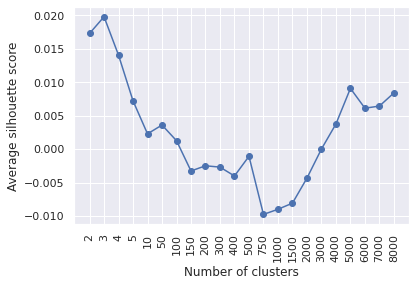

In [13]:
plot_silhouette_scores(ks, pred_cluster_labels["K-medoids clustering"]["metric_values"])

In [ ]:
# TODO: Zoom inn på 4000-6000.
should_pred_cluster_labels_zoomed = True
ks_zoomed = np.linspace(4000, 6000, num=50, dtype=int)
if should_pred_cluster_labels_zoomed:
    pred_cluster_labels_zoomed = cluster_hyperparameters_search(
        clusterers=[
            KMeans
        ],
        clusterer_names=[
            "K-medoids clustering"
        ],
        clusterer_hyperparam_grids=[
            ParameterGrid({
                "n_clusters": ks,
                "random_state": [rng_seed],
                "metric": ["cosine"],
            })
        ],
        vocab_size=vocab_size,
        word_embeddings=last_embedding_weights,
        output_filepath_suffix="k_medoids_labels_zoomed",
        output_dir="../output/word2vec_cluster_analysis",
        model_name="word2vec",
        dataset_name="enwiki"
    )
else:
    with open("../output/word2vec_cluster_analysis/word2vec-enwiki-k_medoids_labels_zoomed.pkl", "rb") as file:
        pred_cluster_labels = pickle.load(file)

In [ ]:
plot_silhouette_scores(ks_zoomed, pred_cluster_labels_zoomed["K-medoids clustering"]["metric_values"])

2 clusters: max=5055, min=4945, ratio=1.0222446916076846


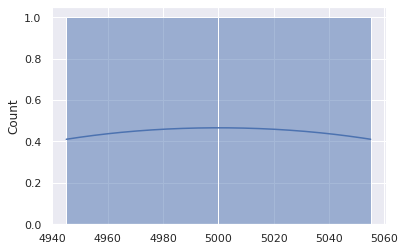

---
3 clusters: max=3701, min=2972, ratio=1.2452893674293406


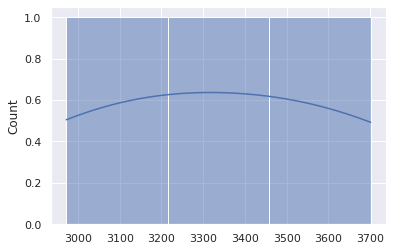

---
4 clusters: max=2874, min=1841, ratio=1.561108093427485


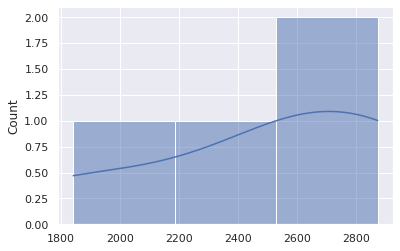

---
5 clusters: max=2704, min=1556, ratio=1.737789203084833


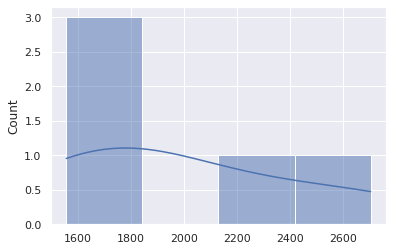

---
10 clusters: max=2072, min=466, ratio=4.446351931330472


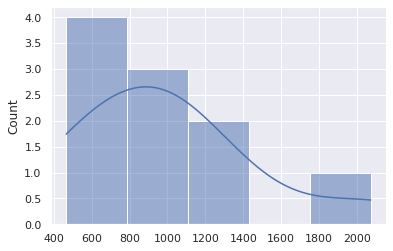

---
50 clusters: max=1043, min=20, ratio=52.15


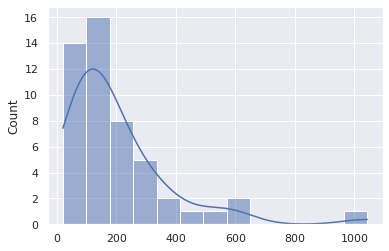

---
100 clusters: max=636, min=10, ratio=63.6


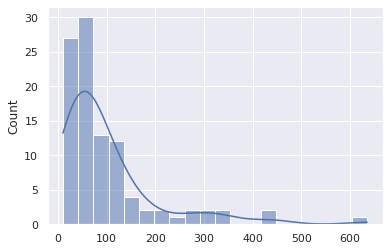

---
150 clusters: max=467, min=4, ratio=116.75


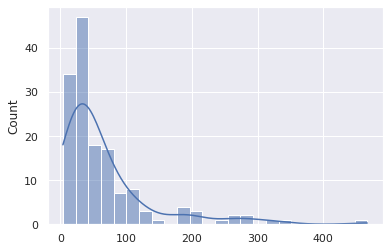

---
200 clusters: max=357, min=2, ratio=178.5


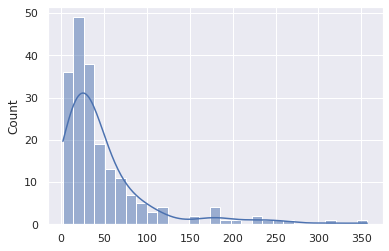

---
300 clusters: max=228, min=1, ratio=228.0


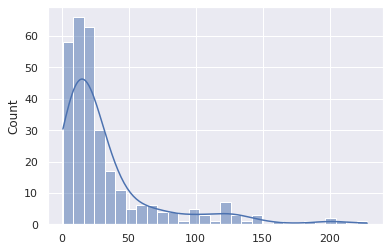

---
400 clusters: max=172, min=1, ratio=172.0


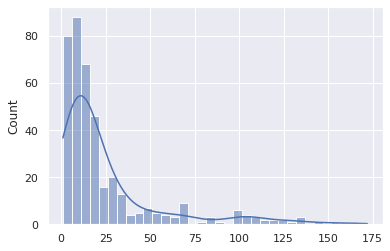

---
500 clusters: max=152, min=1, ratio=152.0


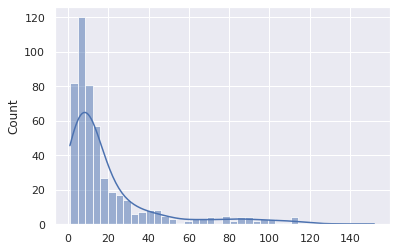

---
750 clusters: max=134, min=1, ratio=134.0


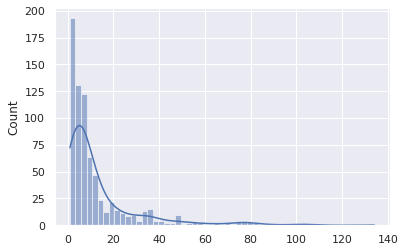

---
1000 clusters: max=102, min=1, ratio=102.0


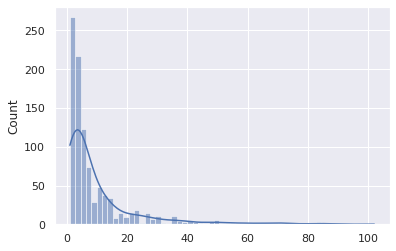

---
1500 clusters: max=84, min=1, ratio=84.0


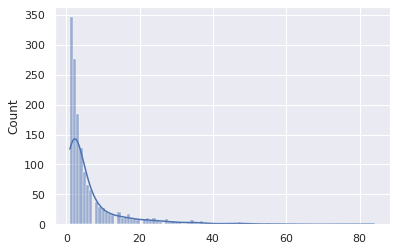

---
2000 clusters: max=69, min=1, ratio=69.0


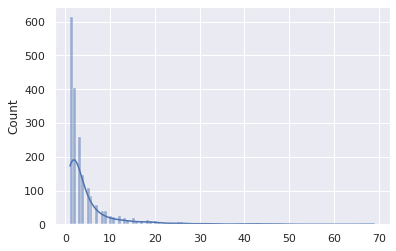

---
3000 clusters: max=44, min=1, ratio=44.0


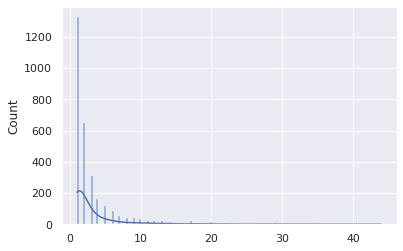

---
4000 clusters: max=40, min=1, ratio=40.0


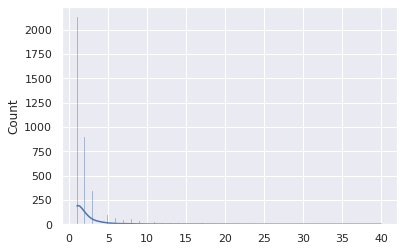

---
5000 clusters: max=35, min=1, ratio=35.0


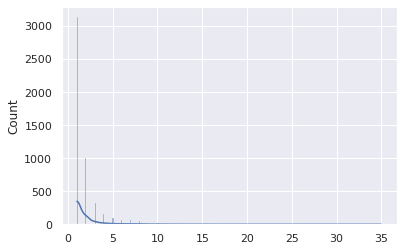

---
6000 clusters: max=26, min=1, ratio=26.0


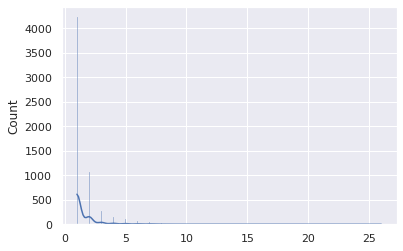

---
7000 clusters: max=30, min=1, ratio=30.0


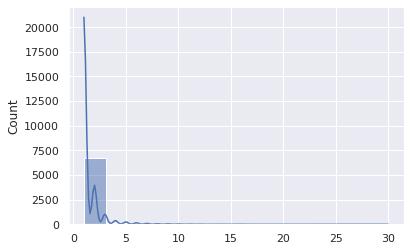

---
8000 clusters: max=15, min=1, ratio=15.0


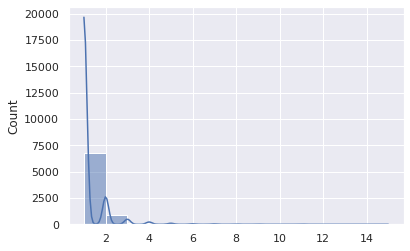

---


In [14]:
# Compute cluster size ratios (maximum cluster size / minimum cluster size)
for labels in pred_cluster_labels["K-medoids clustering"]["labels"]:
    labels_unique, labels_counts = np.unique(labels, return_counts=True)
    num_clusters = len(labels_unique)
    max_cluster_size = max(labels_counts)
    min_cluster_size = min(labels_counts)
    cluster_size_ratio = max_cluster_size / min_cluster_size
    print(f"{num_clusters} clusters: max={max_cluster_size}, min={min_cluster_size}, ratio={cluster_size_ratio}")
    
    # Plot distribution of cluster sizes
    sns.histplot(labels_counts, kde=True)
    plt.show()
    
    print("---")

In [10]:
# Look at the words corresponding to the different clusters (biggest, smallest, etc.)

In [16]:
cluster_words, cluster_sizes = words_in_clusters(
    cluster_labels=pred_cluster_labels["K-medoids clustering"]["labels"][-4],
    words=words[:vocab_size]
)

In [17]:
biggest_cluster_idx = np.argmax(cluster_sizes)
smallest_cluster_idx = np.argmin(cluster_sizes[cluster_sizes >= 5])

In [18]:
cluster_words[biggest_cluster_idx]

array(['river', 'lake', 'valley', 'creek', 'border', 'dam', 'rivers',
       'crossing', 'waters', 'flows', 'basin', 'mouth', 'stream', 'lakes',
       'plain', 'reservoir', 'tributary', 'plains', 'streams', 'pond',
       'brook', 'flowing', 'bend', 'drainage', 'fork', 'watershed',
       'downstream', 'confluence', 'upstream', 'shores', 'tributaries',
       'westward', 'danube', 'dams', 'gorge'], dtype='<U58')

In [19]:
cluster_words[cluster_sizes >= 5][smallest_cluster_idx]

array(['team', 'coach', 'squad', 'coached', 'roster'], dtype='<U58')